In [40]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter, MaxNLocator
import seaborn as sns
sns.set_style("white")
sns.set(context='notebook',
        style='ticks',
        font_scale=1,
        rc={'axes.grid':True,
            'grid.color':'.9',
            'grid.linewidth':0.75})

In [18]:
def mse(p, delta, n, m):
    q = p + delta
    nom = n*p*(1-p) + m*q*(1-q) + m**2*(p-q)**2
    denom = (n+m)**2
    return nom/denom

In [30]:
p = 0.5
delta_list = np.arange(0, 0.3+1e-3, 0.05)
n = 4
m_list = np.arange(0, 20, 0.1)

In [31]:
mse_list = []
for delta in delta_list:
    mse_delta = []
    for m in m_list:
        mse_delta.append(mse(p, delta, n, m))
    mse_list.append(mse_delta)
mse_list = np.array(mse_list)

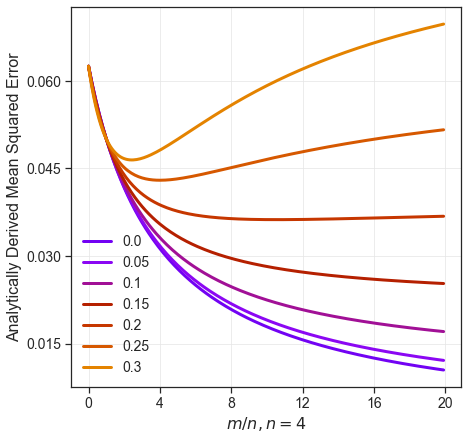

In [41]:
fontsize = 16
labelsize = 14
fig, ax = plt.subplots(figsize=(7, 7))
cmap = [plt.cm.gnuplot(i) for i in np.linspace(0.2, 0.8, len(delta_list))]
for i, delta in enumerate(delta_list):
    ax.plot(m_list, mse_list[i], c=cmap[i], lw=3, label=str(np.round(delta, 2)))
ax.set_ylabel("Analytically Derived Mean Squared Error", fontsize=fontsize)
ax.set_xlabel(r"$m/n, n=4$", fontsize=fontsize)
ax.tick_params(axis='x', labelsize=labelsize)
ax.tick_params(axis='y', labelsize=labelsize)
ax.legend(fontsize=labelsize, frameon=False)
ax.xaxis.set_major_locator(MaxNLocator(6))
ax.yaxis.set_major_locator(MaxNLocator(5))